## Common imports and helpers

In [1]:
psize = (30, 30)
# psize = (15, 15)
# psize = (10, 10)

def load_out(path):
    out = np.load(path)
    return out#[::2,::2]
#     return out.reshape(5, 6, 15, 2).mean(3).mean(1)
#     return out.reshape(5,6, 5, 6).mean(3).mean(1)
    return out.reshape(10, 3, 10, 3).mean(3).mean(1)

def get_manip_mask(manip_mask, thres=0.1, patch_size=64):
#     manip_mask = (manip_mask == 255).astype('float32')
#     manip_mask_ds = cv2.resize(manip_mask, psize[::-1], interpolation=cv2.INTER_AREA)
#     return (manip_mask_ds > thres).astype('uint8')
    msize = psize # 
    msize = (30, 30)
    manip_mask = (manip_mask > 0).astype(np.uint8)
    label = np.empty(msize, dtype=np.uint8)
    im_h, im_w = manip_mask.shape
    for ih, h in enumerate(np.linspace(0, im_h - patch_size, msize[0]).astype(int)):
        for iw, w in enumerate(np.linspace(0, im_w - patch_size, msize[1]).astype(int)):
            label[ih, iw] = int(np.mean(manip_mask[h:h+patch_size, w:w+patch_size]) > thres)
    return label#[::2,::2]#.reshape(5, 6, 15, 2).mean(3).mean(1) > thres
#     manip_mask = (manip_mask == 255).astype('float32')
#     manip_mask_ds = cv2.resize(manip_mask, psize, interpolation=cv2.INTER_AREA)
#     return (manip_mask_ds > thres).astype('uint8')

# CAF

In [2]:
# BIG mAP
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
from torchvision import transforms
from util import renormalize, show, losses
import lpips
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 8)
import cv2
import glob
import os


version = 'v1'
loss_type = 'LPIPS' # 'LPIPS'
# loss_type = 'L1' # 'LPIPS'

# Has the heatmap and npys 
folder = f'/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/notebooks/detection_results_CAF/{version}_{loss_type}_30x30_results/'
fnames = os.listdir(folder)
fnames = sorted([fname for fname in fnames if 'raw.npy' in fname])
im_w, y_valid = 1412, 534
manip_folder = '/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/data/content-aware-v3-div4-crop/'
ds = 4
source_dir = '/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/data/source-div%s-crop/' % str(ds)

# fake predictions and labels
fake_scores1 = []
fake_labels1 = []
for fname in fnames:
    out = load_out(os.path.join(folder, fname)) # (30, 30)
#     out_up = cv2.resize(out, (im_w, y_valid), cv2.INTER_CUBIC)
    exp_name = fname[:8]+f'c_{version}'
    
    # load protect mask to filter
    path_protect = os.path.join(source_dir, f'{exp_name}_protect_mask.png')
    protect_mask = cv2.imread(path_protect)[:y_valid, :, 0]
#     assert len(np.unique(protect_mask)) == 2
    protect_mask_ds = cv2.resize(protect_mask, psize[::-1], cv2.INTER_AREA)
    protect_filter = np.where(protect_mask_ds > 0)
#     path_mask = os.path.join(source_dir, 'totem_mask.png')
#     other_filter = np.where(protect_mask != 255)

    # load manip mask to label
    path_manip_mask = os.path.join(manip_folder, fname[:31] + '_mask.png')
    manip_mask = cv2.imread(path_manip_mask)[:y_valid, :, 0]
    manip_mask_ds = get_manip_mask(manip_mask)
#     manip_mask = (manip_mask == 255).astype('uint8')
#     manip_mask_ds = cv2.resize(manip_mask, psize, cv2.INTER_NEAREST)
    
    fake_scores1.append(out[protect_filter])
    fake_labels1.append(manip_mask_ds[protect_filter])

    
fake_scores1 = np.concatenate(fake_scores1)
fake_labels1 = np.concatenate(fake_labels1)

In [3]:
manip_mask_ds.shape

(30, 30)

In [4]:
manip_mask.shape

(534, 1412)

In [5]:
534/10

53.4

In [6]:
1412/30

47.06666666666667

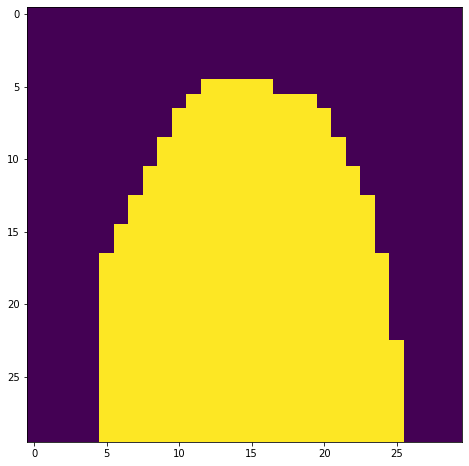

In [7]:
plt.imshow(protect_mask_ds > 0)

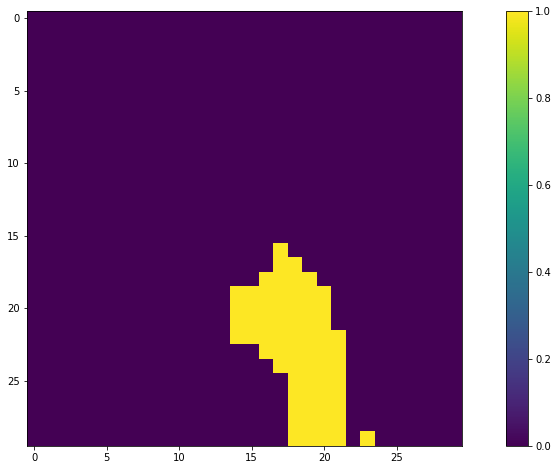

In [8]:
plt.imshow(manip_mask_ds)
plt.colorbar()

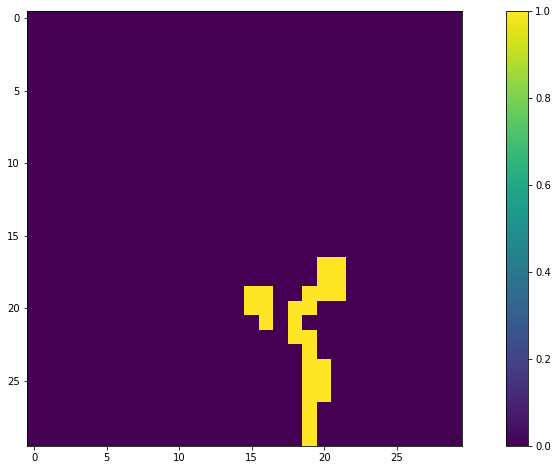

In [9]:
plt.imshow(out * (protect_mask_ds > 0) > 0.7)
plt.colorbar()

# Real

In [10]:
# real predictions and labels
real_scores = []
real_fnames = sorted(list(set([fname[:8] for fname in fnames])))
real_folder = f'/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/notebooks/detection_results_CAF_real/{version}_{loss_type}_30x30_results/'
ds = 4
source_dir = '/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/data/source-div%s-crop/' % str(ds)

for fname in real_fnames:
    out = load_out(os.path.join(real_folder, fname+'_raw.npy')) # (30, 30)
#     out_up = cv2.resize(out, (im_w, y_valid), cv2.INTER_CUBIC)
    exp_name = fname[:8]+f'c_{version}'
    
    # load protect mask
    path_protect = os.path.join(source_dir, f'{exp_name}_protect_mask.png')
    protect_mask = cv2.imread(path_protect)[:y_valid, :, 0]
    protect_mask_ds = cv2.resize(protect_mask, psize[::-1], cv2.INTER_AREA)
    protect_filter = np.where(protect_mask_ds > 0)
#     path_mask = os.path.join(source_dir, 'totem_mask.png')
#     other_filter = np.where(protect_mask != 255)
    
#     # Replace values in unprotected area with 0.0
#     out_up[other_filter] = 0.0
#     im_score = np.max(out_up)
#     real_scores.append(im_score)
    real_scores.append(out[protect_filter])

real_scores = np.concatenate(real_scores)
real_labels = np.zeros(len(real_scores))

# Splice

In [11]:
# Has the heatmap and npys 
folder = f'/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/notebooks/detection_results_splice/{version}_{loss_type}_30x30_results/'
fnames = os.listdir(folder)
fnames = sorted([fname for fname in fnames if 'raw.npy' in fname])
im_w, y_valid = 1412, 534
manip_folder = '/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/data/content-aware-v2c-div4-crop/'
ds = 4
source_dir = '/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/data/source-div%s-crop/' % str(ds)

# fake predictions and labels
fake_scores2 = []
fake_labels2 = []
for fname in fnames:
    out = load_out(os.path.join(folder, fname)) # (30, 30)
#     out_up = cv2.resize(out, (im_w, y_valid), cv2.INTER_CUBIC)
    exp_name = fname[:8]+f'c_{version}'
    
    # load protect mask
    path_protect = os.path.join(source_dir, f'{exp_name}_protect_mask.png')
    protect_mask = cv2.imread(path_protect)[:y_valid, :, 0]
    protect_mask_ds = cv2.resize(protect_mask, psize[::-1], cv2.INTER_AREA)
    protect_filter = np.where(protect_mask_ds > 0)
    
    # load manip mask to label
    path_manip_mask = os.path.join(manip_folder, fname[9:-8] + '.png')
    manip_mask = cv2.imread(path_manip_mask)[:y_valid, :, 0]
#     manip_mask = (manip_mask == 255).astype('uint8')
#     manip_mask_ds = cv2.resize(manip_mask, psize, cv2.INTER_NEAREST)
    manip_mask_ds = get_manip_mask(manip_mask)
    
    fake_scores2.append(out[protect_filter])
    fake_labels2.append(manip_mask_ds[protect_filter])
    
fake_scores2 = np.concatenate(fake_scores2)
fake_labels2 = np.concatenate(fake_labels2)


# Patch

In [12]:
len(fnames)

8

In [13]:
# Has the heatmap and npys 
folder = f'/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/notebooks/detection_results_patch/{version}_{loss_type}_30x30_results/'
fnames = os.listdir(folder)
fnames = sorted([fname for fname in fnames if 'raw.npy' in fname])
im_w, y_valid = 1412, 534
manip_folder = '/data/vision/phillipi/gan-training/totem/resources/totems/data/manip_patch/'
ds = 4
source_dir = '/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems-misc/data/source-div%s-crop/' % str(ds)

# fake predictions and labels
fake_scores3 = []
fake_labels3 = []
for fname in fnames:
    out = load_out(os.path.join(folder, fname)) # (30, 30)
#     out_up = cv2.resize(out, (im_w, y_valid), cv2.INTER_CUBIC)
    exp_name = fname[:8]+f'c_{version}'
    
    # load protect mask
    path_protect = os.path.join(source_dir, f'{exp_name}_protect_mask.png')
    protect_mask = cv2.imread(path_protect)[:y_valid, :, 0]
    protect_mask_ds = cv2.resize(protect_mask, psize[::-1], cv2.INTER_AREA)
    protect_filter = np.where(protect_mask_ds > 0)
    
    # load manip mask to label
    path_manip_mask = os.path.join(manip_folder, fname[:11] + 'mask.png')
    manip_mask = cv2.imread(path_manip_mask)[:y_valid, :, 0]
#     manip_mask = (manip_mask == 255).astype('uint8')
#     manip_mask_ds = cv2.resize(manip_mask, psize, cv2.INTER_NEAREST)
    manip_mask_ds = get_manip_mask(manip_mask)
    
    fake_scores3.append(out[protect_filter])
    fake_labels3.append(manip_mask_ds[protect_filter])
    
fake_scores3 = np.concatenate(fake_scores3)
fake_labels3 = np.concatenate(fake_labels3)


# Merging

In [14]:
def print_stats(scores, labels):
    mAP = metrics.average_precision_score(labels, scores, average='weighted')
    print('Number of manipulated patches: ', np.sum(labels))
    print('Number of unmanipulated patches: ', len(labels)-np.sum(labels))
    print(np.sum(labels) / len(labels))
    print('mAP: ', mAP)

In [16]:
import seaborn as sns

In [17]:
import pandas as pd

In [18]:
data = []

for ii in range(len(fake_scores1)):
    label = fake_labels1[ii]
    data.append(dict(
        type='Real' if not label else 'CAF', 
        score=fake_scores1[ii].item(), 
        source='CAF',
        label=label,
    ))
for ii in range(len(fake_scores2)):
    label = fake_labels2[ii]
    data.append(dict(
        type='Real' if not label else 'Splicing', 
        score=fake_scores2[ii].item(), 
        source='Splicing',
        label=label,
    ))
for ii in range(len(fake_scores3)):
    label = fake_labels3[ii]
    data.append(dict(
        type='Real' if not label else 'Color', 
        score=fake_scores3[ii].item(), 
        source='Color',
        label=label,
    ))
for ii in range(len(real_scores)):
    assert real_labels[ii] == 0
    data.append(dict(
        type='Real', 
        score=real_scores[ii].item(), 
        source='Real',
        label=0,
    ))

In [19]:
data = pd.DataFrame(data)

In [20]:
data

,type,score,source,label
0,Real,0.528647,CAF,0
1,Real,0.597675,CAF,0
2,Real,0.544581,CAF,0
3,Real,0.521227,CAF,0
4,Real,0.541915,CAF,0
...,...,...,...,...
17059,Real,0.417618,Real,0
17060,Real,0.502019,Real,0
17061,Real,0.426905,Real,0
17062,Real,0.480781,Real,0


In [21]:
!mkdir -p ./patch_detection_out_09232022

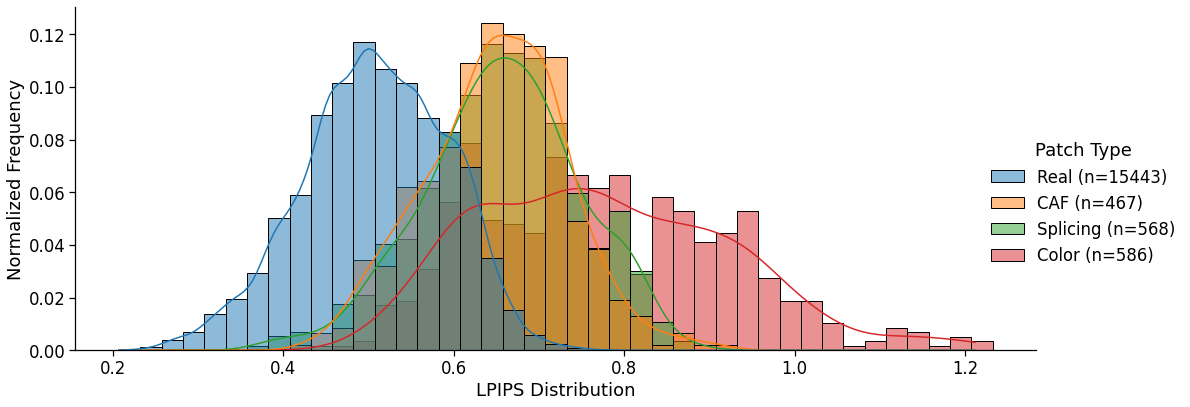

In [22]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.displot(data, x='score', hue='type', binwidth=0.025, kde=True, height=6, aspect=2.5, stat='probability', common_norm=False)
plt.gca().set_xlabel(f'{loss_type} Distribution')
plt.gca().set_ylabel('Normalized Frequency')

g._legend.set_title('Patch Type')

for t in g._legend.texts: 
    t.set_text(t.get_text() + f" (n={len(data[data['type'] == t.get_text()])})")
    
plt.gcf().savefig(f'patch_detection_out_09232022/patch_score_distn_{loss_type.lower()}.pdf', dpi=100)

In [23]:
g._legend.texts[0].get_text()

'Real (n=15443)'

In [24]:
len(data[data['type'] == 'Real'])

15443

In [25]:
!pwd

/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/totems/notebooks


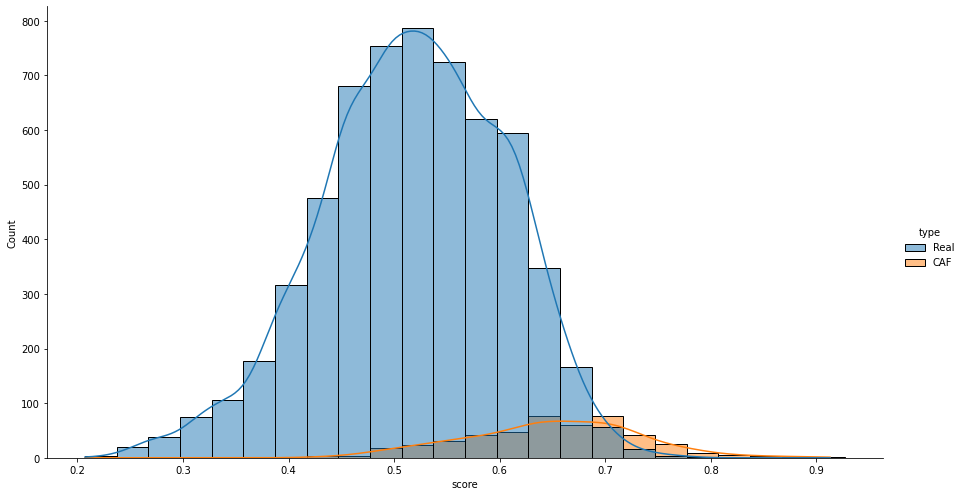

In [26]:
sns.displot(data[data['source'].isin(['CAF', 'Real'])], x='score', hue='type', binwidth=0.03, kde=True, height=7, aspect=1.8, stat='count', common_norm=False)

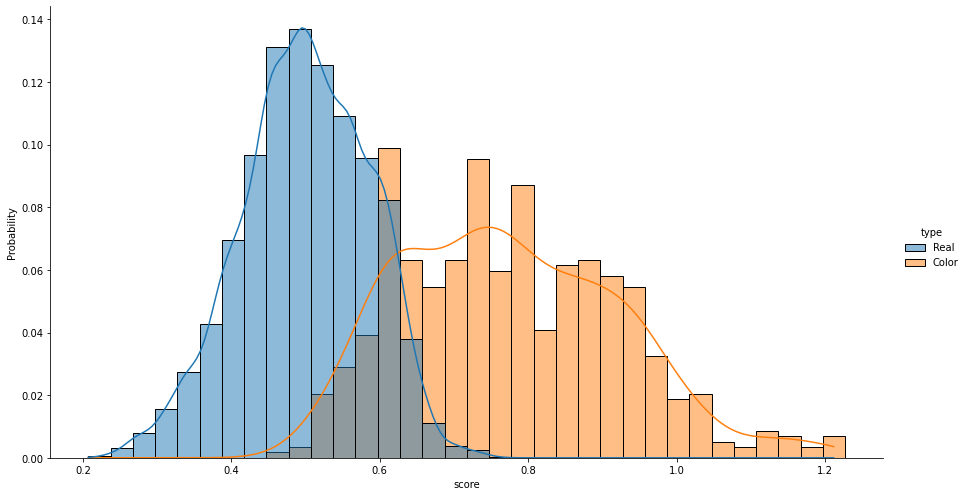

In [27]:
sns.displot(data[data['source'].isin(['Color', 'Real'])], x='score', hue='type', binwidth=0.03, kde=True, height=7, aspect=1.8, stat='probability', common_norm=False)

In [28]:
sub = data[data['source'].isin(['CAF', 'Real'])]

In [29]:
print_stats(
    sub['score'].tolist(),
    sub['label'].tolist(),
)

Number of manipulated patches:  467
Number of unmanipulated patches:  5965
0.07260572139303482
mAP:  0.495419105294521


In [30]:
# Table 1, column 4, row 2 and 3
scores = np.concatenate([fake_scores1, fake_scores2, fake_scores3, real_scores])
labels = np.concatenate([fake_labels1, fake_labels2, fake_labels3, real_labels])
print('All patches in all datasets')
print_stats(scores, labels)

All patches in all datasets
Number of manipulated patches:  1621.0
Number of unmanipulated patches:  15443.0
0.09499531176746366
mAP:  0.708645798719385


In [31]:
print('All patches in CAF')
print_stats(fake_scores1, fake_labels1)

All patches in CAF
Number of manipulated patches:  467
Number of unmanipulated patches:  2749.0
0.14521144278606965
mAP:  0.5752827487401846


In [32]:
print('All patches in splicing')
print_stats(fake_scores2, fake_labels2)

All patches in splicing
Number of manipulated patches:  568
Number of unmanipulated patches:  3143.0
0.15305847480463486
mAP:  0.7423979857121863


In [33]:
print('All patches in color patch')
print_stats(fake_scores3, fake_labels3)

All patches in color patch
Number of manipulated patches:  586
Number of unmanipulated patches:  6335.0
0.08466984539806387
mAP:  0.8503904087435216


In [34]:
print('All patches in original images')
print_stats(real_scores, real_labels)

All patches in original images
Number of manipulated patches:  0.0
Number of unmanipulated patches:  3216.0
0.0
mAP:  nan


/data/vision/torralba/virtualhome/realvirtualhome/realvirtualhome/totem/nerf-pytorch/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [35]:
# Table 1, column 1, row 2 and 3
scores = np.concatenate([fake_scores1, real_scores])
labels = np.concatenate([fake_labels1, real_labels])
print('CAF + real')
print_stats(scores, labels)

CAF + real
Number of manipulated patches:  467.0
Number of unmanipulated patches:  5965.0
0.07260572139303482
mAP:  0.495419105294521


In [36]:
# Table 1, column 2, row 2 and 3
scores = np.concatenate([fake_scores2, real_scores])
labels = np.concatenate([fake_labels2, real_labels])
print('splice + real')
print_stats(scores, labels)

splice + real
Number of manipulated patches:  568.0
Number of unmanipulated patches:  6359.0
0.08199797892305472
mAP:  0.6315060326524435


In [37]:
# Table 1, column 3, row 2 and 3
scores = np.concatenate([fake_scores3, real_scores])
labels = np.concatenate([fake_labels3, real_labels])
print('color + real')
print_stats(scores, labels)

color + real
Number of manipulated patches:  586.0
Number of unmanipulated patches:  9551.0
0.05780802998914866
mAP:  0.8169091502907349
